# Investigate Sea Level rise in ACCESS-OM2 OMIP model

This is an adaptation of a [COSIMA Recipe comparing sea level in a number of resolutions to observed sea level data](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Compare_SSH_model_obs.html).

Rather than compare to observations in this notebook we will make a climatology of the early part of the model run, and compute anomalies for the last 18 years of the experiment.

In [1]:
import cosima_cookbook as cc
import cf_xarray

This is relatively computationally intensive, so we'll need a dask client to parallelise the workflow. Paste the dashboard_link that is printed below the cell into the dask window on the left to see live updates of the progress of the job

In [2]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

Create a connection to the COSIMA Cookbook database, define the experiment and variable we want to use (same ones we found in the previous notebook)

In [3]:
session = cc.database.create_session()

In [4]:
experiment_name = "1deg_jra55_iaf_omip2_cycle6"
variable_name = "sea_level"

Re-use the command copied from the Experiment Explorer when we loaded this variable. In this case though we want the whole time range of the data, so won't specify `start_date` and `end_date`

In [5]:
%%time
variable = cc.querying.getvar(expt=experiment_name, variable=variable_name, 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'})

CPU times: user 1.69 s, sys: 609 ms, total: 2.3 s
Wall time: 15.2 s


In [6]:
variable

<xarray.DataArray 'sea_level' (time: 22280, yt_ocean: 300, xt_ocean: 360)>
dask.array<concatenate, shape=(22280, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 1957-12-30T12:00:00 ... 2018-12-29T12:00:00
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cy...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-03-03
    description:    1 degree ACCESS-OM2 global model configuration under inte...

Make a climatology from the first thirty years of data which we'll use to compare with later time periods. This requires reading in a large number of files, so can take a while to complete

In [7]:
%%time
sea_level_climatology = variable.sel(time=slice('1957', '1986')).mean('time').compute()

CPU times: user 30.3 s, sys: 1.78 s, total: 32.1 s
Wall time: 1min 10s


In [8]:
sea_level_climatology

<xarray.DataArray 'sea_level' (yt_ocean: 300, xt_ocean: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

It is always a good idea to make a plot to eyeball the data

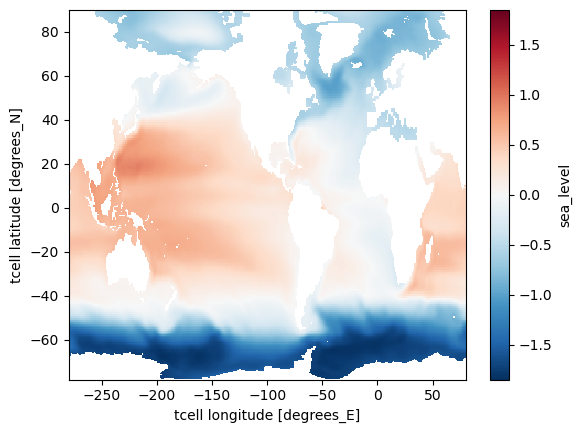

In [9]:
sea_level_climatology.plot()

Let's explore a science question. Is there a trend in `sea_level` anomalies since the year 2000? Are there any spatial patterns if there is a systematic change?

So the next step is to calculate anomalies for all the data from the year 2000 onwards, and find the mean for each year. This is the really expensive calculation on because it has to subtract the climatology first

In [10]:
%%time
sea_level_anomalies = (variable.sel(time=slice('2000',None)) - sea_level_climatology).resample({'time': '1Y'}).mean('time').compute()

CPU times: user 44.7 s, sys: 2.32 s, total: 47 s
Wall time: 1min 56s


<details>
  <summary>Click if you're short on time</summary>
The `sea_level_anomalies` data is available on disk in case we ran out of time. You can load it directly:

```python
sea_level_anomalies = xr.open_dataset('/scratch/public/COSIMA_tutorial/climatology.nc')
```
</details>

#### Exercise 1

Make a (line) plot of mean sea level by year, i.e. take the mean over the spatial dimensions for each year.

Hint: this can be done in a single line

<details>
  <summary>Click for answer</summary>

```python
sea_level_anomalies.mean(dim=('xt_ocean', 'yt_ocean')).plot()
```
</details>

#### Exercise 2

Now make two plots the same as the last, but one for each hemisphere, to see if there are any trends more evident in one hemisphere than the other

<details>
  <summary>Click for answer</summary>

```python
sea_level_anomalies.sel(yt_ocean=slice(-90,0)).mean(dim=('xt_ocean', 'yt_ocean')).plot()
sea_level_anomalies.sel(yt_ocean=slice(0,90)).mean(dim=('xt_ocean', 'yt_ocean')).plot()
```
</details>

#### Exercise 3

Lastly make a [facet plot](https://docs.xarray.dev/en/latest/user-guide/plotting.html#faceting) showing the mean anomaly for each year to see if there are any spatial patterns to the sea level anomalies.

Hint: this does not involve any calculations

<details>
  <summary>Click for answer</summary>

```python
sea_level_anomalies.plot(col="time", col_wrap=4)
```
</details>